# Lesson 6: pets revisited

In [13]:
# 三行魔法代码
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [14]:
bs = 64 # 批量设置

In [15]:
path = untar_data(URLs.PETS)/'images' # 图片全部在一个文件夹中

In [16]:
# 图片变形设计
tfms = get_transforms(max_rotate=20, # 以后逐一尝试
                      max_zoom=1.3, 
                      max_lighting=0.4, 
                      max_warp=0.4,
                      p_affine=1., 
                      p_lighting=1.)

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

ItemLists;

Train: ImageList (5912 items)
Image (3, 186, 175),Image (3, 375, 500),Image (3, 404, 500),Image (3, 500, 500),Image (3, 333, 500)
Path: /tmp/.fastai/data/oxford-iiit-pet/images;

Valid: ImageList (1478 items)
Image (3, 333, 500),Image (3, 375, 500),Image (3, 333, 500),Image (3, 332, 500),Image (3, 375, 500)
Path: /tmp/.fastai/data/oxford-iiit-pet/images;

Test: None

ImageList (2 items)
Image (3, 186, 175),Image (3, 375, 500)
Path: /tmp/.fastai/data/oxford-iiit-pet/images

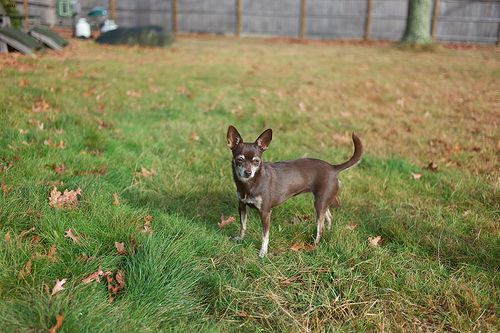

fastai.vision.data.ImageList

fastai.data_block.ItemLists

In [31]:
# 将图片夹转化成ImageList
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2) # 无需单独做np.random.seed(2)
src
src.train[0:2] # 查看训练集中图片
src.valid[0] # 直接看图
src.train.__class__ # fastai.vision.data.ImageList
src.__class__ # fastai.data_block.ItemLists

In [10]:
# 快捷生成DataBunch
def get_data(size, bs, padding_mode='reflection'): # 提供图片尺寸，批量和 padding模式
    return (src.label_from_re(r'([^/]+)_\d+.jpg$') # 从图片名称中提取label标注
           .transform(tfms, size=size, padding_mode=padding_mode) # 对图片做变形
           .databunch(bs=bs).normalize(imagenet_stats))

fastai.data_block.LabelList

(Image (3, 224, 224), Category Bombay)

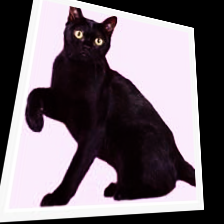

Category Bombay

fastai.core.Category

fastai.vision.image.Image

In [38]:
data = get_data(224, bs, 'zeros') # 图片统一成224的尺寸
data.train_ds.__class__ # fastai.data_block.LabelList 所以可以像list一样提取数据
data.train_ds[0]
data.train_ds[0][0] # 提取同一张图片，但是不同的变形？Image class
data.train_ds[0][1] # 提取label， Category class
data.train_ds[0][1].__class__
data.train_ds[0][0].__class__

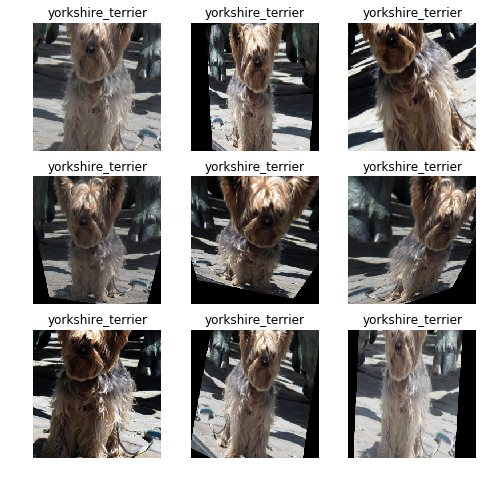

In [12]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [ ]:
data = get_data(224,bs)

In [ ]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [ ]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [ ]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

In [ ]:
data = get_data(352,bs)
learn.data = data

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save('352')

## Convolution kernel

In [ ]:
data = get_data(352,16)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [ ]:
k

In [ ]:
k.shape

In [ ]:
t = data.valid_ds[0][0].data; t.shape

In [ ]:
t[None].shape

In [ ]:
edge = F.conv2d(t[None], k)

In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
data.c

In [ ]:
learn.model

In [ ]:
print(learn.summary())

## Heatmap

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

## fin